Import relevant packages and import custom syntethic data generation class "CameraProjection"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from road_anomaly_detector.main.calibration.Camera_calibration.synthetic_data import CameraProjection


Overview of Functions
1. **Cross Ratio Calculation**
The cross_ratio function computes the cross-ratio of four points in a 1D space. This ratio is an important geometric invariant in projective geometry.

2. **Feature Points Correspondences**
The feature_points_correspondences function calculates feature points in both diagonal and vertical directions based on the provided image coordinates. It then interlaces these points to form a pattern coordinate array.

3. **Projecting 1D to 2D Feature Points**
The project_feature_points_1d_to_2d function projects 1D feature points onto a 2D plane by rotating them 90 degrees, simulating a projection transformation. This operation is particularly useful for transforming points in a 1D calibration setup into a 2D space.

4. **Finding Optical Pattern**
The find_optical_pattern function determines the pattern coordinates that correspond to an optical center by interpolating between image coordinates and pattern coordinates. This function is essential for aligning image coordinates with pattern geometry.

5. **Projecting Pattern Points**
The project_pattern_points function performs a simulated rotation around an optical center by projecting pattern points based on an optical reference. This enables the transformation of points to a rotated view.

6. **Calibration from Homographies**
The calibrate_from_homographies function uses homography matrices to calculate the intrinsic camera matrix, represented as 
𝑀
M, along with extrinsic parameters (rotation matrix 
𝑅
R and translation vector 
𝑡
t). The calibration uses singular value decomposition (SVD) to ensure that the intrinsic and extrinsic parameters are as accurate as possible.

7. **Calibration from Homographies with Levenberg-Marquardt Algorithm**
The calibrate_from_homographies_LMA_updated function is an extension of the previous calibration function. It employs the Levenberg-Marquardt algorithm to iteratively refine the intrinsic and extrinsic parameters. This function leverages the optimization method to minimize errors in calibration and better approximate real-world camera parameters.

In [11]:
# Step 2 feature point correspondences

def cross_ratio(unit):
    if unit.size != 4 or unit.ndim != 1:
        raise ValueError("Input must be a 1D numpy array with exactly four elements.")
    
    A, B, C, D = unit
    return ((C-A) / (C-B)) / ((D-A) / (D-B))


def feature_points_correspondences(X_image_coordinates, h, l):
    # P D P D P D P

    # Pad last vertical line based on ca = da * 2
    ca_last = X_image_coordinates[-1] - X_image_coordinates[-3]
    X_image_coordinates = np.append(X_image_coordinates, [0, X_image_coordinates[-1] + ca_last])
    
    #Find all diagonal X in pattern coordinates
    i = 1
    diagonal = []
    for i_cross in range(0, len(X_image_coordinates) - 4, 2):  # Move 2 steps forward each iteration
        # Find ABCD according to figure 2 in paper
        ABCD = X_image_coordinates[[i_cross, i_cross+1, i_cross+2, i_cross+4]] # A B C D
        # Cross ratio
        r_abcd = cross_ratio(ABCD)
        eta = (2*r_abcd-2) / (2*r_abcd-1)
        # Find X
        x_b = eta * h + (i-1)*h
        # Find Y
        y_b = (l/h) * x_b - (i - 1) * l
        # Next diagonal line
        i = i + 1
        #append
        diagonal.append([x_b, y_b])

    #Find all other lines
    diagonal = np.array(diagonal) 
    vertical = []
    for i in range(0, len(diagonal), 2):
        x_a = i*h
        if i != 0:
            x_c = (i+1)*h
        else:
            x_c = 1*h

        # Extract coordinates from diagonals
        if i != len(diagonal)-1:
            dia_points = diagonal[[i,i+1]]
        else:
            dia_points = diagonal[[i-1, i]]

        x1, y1 = dia_points[0]
        x2, y2 = dia_points[1]
        # Calculate slope (m)
        m = (y2 - y1) / (x2 - x1)
        # Calculate y-intercept (b)
        b = y1 - m * x1
        # Calculate y
        y_a = m * x_a + b
        y_c = m * x_c + b
        # append
        vertical.append([x_a,y_a])
        vertical.append([x_c, y_c])

    vertical = np.array(vertical)
    # Create an empty array for interlaced coordinates
    pattern_coordinates = np.empty((diagonal.shape[0] + vertical.shape[0], 2), dtype=diagonal.dtype)

    # Interlace arrays
    pattern_coordinates[0::2] = vertical  # Place `vertical` elements at even rows
    pattern_coordinates[1::2] = diagonal  # Place `diagonal` elements at odd rows
    #print(diagonal.shape)
    #print(vertical.shape)
    return pattern_coordinates

def project_feature_points_1d_to_2d(points_1d, u):
    """
    Projects 1D feature points onto a 2D space by rotating 90 degrees around an estimated optical center.
    ASSUMING FIRST PART OF ARRAY IS POINTS AND NEXT PART IS PROJECTION
    """
    # Start by finding points
    Y = np.ones(np.size(points_1d)) * u
    points_2d = np.vstack((points_1d, Y)).T

    # Find projection
    rotation_matrix = np.array([[0, -1], [1, 0]])
    points_2d_projection = []

    for point in points_1d:
        # Map 1D points to 2D by duplicating the contrast
        point_2d_projection = rotation_matrix @ (np.array([point, u]) - np.array([u, u])) + np.array([u, u])
        points_2d_projection.append(point_2d_projection)
    
    

    return np.vstack((points_2d,points_2d_projection))

def find_optical_pattern(image_coords, pattern_coords, u):
    low_index = np.searchsorted(image_coords,u)

    Pattern_low = pattern_coords[low_index-1]
    Pattern_high = pattern_coords[low_index]

    dist_u_image = u - image_coords[low_index-1]
    dist_image = image_coords[low_index] - image_coords[low_index-1]
    dist_pattern = Pattern_high[0] - Pattern_low[0]

    Pattern_to_Image = dist_pattern/dist_image
    dist_u_pattern = Pattern_to_Image * dist_u_image

    x_a = Pattern_low[0]+dist_u_pattern
    x1, y1 = Pattern_low
    x2, y2 = Pattern_high
    # Calculate slope (m)
    m = (y2 - y1) / (x2 - x1)
    # Calculate y-intercept (b)
    b = y1 - m * x1
    # Calculate y
    y_a = m * x_a + b

    return np.array([x_a, y_a])

def project_pattern_points(image_coords, pattern_coords, optical_center):
    #find optical pattern
    pattern_optical = find_optical_pattern(image_coords, pattern_coords, optical_center)
    
    #rotate
    rotation_matrix = np.array([
        [0, -1],
        [1, 0]
    ])

    translated_points = pattern_coords - pattern_optical
    rotated_translated_points = translated_points @ rotation_matrix.T
    rotated_pattern_coords = rotated_translated_points + pattern_optical

    return np.vstack((pattern_coords,rotated_pattern_coords))

def calibrate_from_homographies(H_list):
    # Prepare the matrix V from homographies
    V = []

    for H in H_list:
        H = H / H[2, 2]  # Normalize H to make H[2,2] = 1
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute v_12^T * b = 0
        v12 = np.array([
            h1[0]*h2[0] + h1[1]*h2[1],
            (h1[0]+h1[1])*h2[2] + (h2[0]+h2[1])*h1[2],
            h1[2]*h2[2]
        ])

        # Compute (v_11 - v_22)^T * b = 0
        v11 = np.array([
            h1[0]*h1[0] + h1[1]*h1[1],
            2*(h1[0]+h1[1])*h1[2],
            h1[2]*h1[2]
        ])
        v22 = np.array([
            h2[0]*h2[0] + h2[1]*h2[1],
            2*(h2[0]+h2[1])*h2[2],
            h2[2]*h2[2]
        ])
        v_diff = v11 - v22

        V.append(v12)
        V.append(v_diff)

    V = np.array(V)

    # Solve Vb = 0 using SVD
    U, S, VT = np.linalg.svd(V)
    b = VT[-1, :]  # Solution is the last row of V^T corresponding to smallest singular value

    # Extract intrinsic parameters from b
    B11 = b[0]
    B13 = b[1]
    B33 = b[2]

    # Compute intrinsic parameters
    fx = np.sqrt(1 / B11)
    u0 = -B13 * fx**2
    fy = fx  # Since fx = fy
    v0 = u0  # Since u0 = v0
    k = 0    # Skew is zero

    # Construct the intrinsic matrix M
    M = np.array([
        [fx, k,  u0],
        [0,  fy, v0],
        [0,  0,  1]
    ])

    print("Intrinsic Matrix M:")
    print(M)

    # Compute extrinsic parameters for each homography
    extrinsics = []
    for H in H_list:
        H = H / H[2, 2]  # Normalize H
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute lambda (scale factor)
        inv_M = np.linalg.inv(M)
        lambda_ = 1 / np.linalg.norm(np.dot(inv_M, h2))

        # Compute rotation vectors
        r1 = lambda_ * np.dot(inv_M, h1)
        r2 = lambda_ * np.dot(inv_M, h2)
        r3 = np.cross(r1, r2)

        # Ensure orthonormality of rotation matrix using SVD
        R = np.column_stack((r1, r2, r3))
        #U_R, _, Vt_R = np.linalg.svd(R)
        #R = np.dot(U_R, Vt_R)

        # Compute translation vector
        t = lambda_ * np.dot(inv_M, h3)

        extrinsics.append({'R': R, 't': t})

    # Calibrate the camera

    for idx, extrinsic in enumerate(extrinsics):
        print(f"\nExtrinsic Parameters for Homography {idx+1}:")
        print("Rotation Matrix R:")
        print(extrinsic['R'])
        print("Translation Vector t:")
        print(extrinsic['t'])

    return M, extrinsics

from scipy.optimize import least_squares
def calibrate_from_homographies_LMA(H_list):
    """
    Calibrates the camera intrinsic and extrinsic parameters from given homographies using Levenberg-Marquardt algorithm.

    Parameters:
    H_list (list of numpy.ndarray): List of 3x3 homography matrices.

    Returns:
    M (numpy.ndarray): The 3x3 camera intrinsic matrix.
    extrinsics (list of dict): A list containing the extrinsic parameters (R, t) for each homography.
    """
    # Prepare data for optimization
    def residuals(b, H_list):
        # b contains the unique elements of B: [B11, B13, B33]
        B11, B13, B33 = b
        residuals = []

        for H in H_list:
            H = H / H[2, 2]  # Normalize H to make H[2,2] = 1
            h1 = H[:, 0]
            h2 = H[:, 1]

            # Construct symmetric matrix B
            B = np.array([
                [B11, 0,    B13],
                [0,    B11, B13],
                [B13, B13, B33]
            ])

            # Compute constraints
            v12 = np.dot(h1.T, np.dot(B, h2))
            v11 = np.dot(h1.T, np.dot(B, h1))
            v22 = np.dot(h2.T, np.dot(B, h2))

            # Residuals from the two equations
            residuals.append(v12)
            residuals.append(v11 - v22)

        return residuals

    # Initial guess for b
    b0 = np.array([1, 0, 1])

    # Use Levenberg-Marquardt algorithm to minimize the residuals
    result = least_squares(residuals, b0, args=(H_list,), method='lm')

    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)

    B11, B13, B33 = result.x

    # Compute intrinsic parameters
    # Ensure that fx is positive
    fx = np.sqrt(1 / B11)
    if fx < 0:
        fx = -fx
    fy = fx  # Since fx = fy

    # Compute u0
    u0 = -B13 * fx**2
    v0 = u0  # Since u0 = v0

    # Skew is zero
    k = 0

    # Construct the intrinsic matrix M
    M = np.array([
        [fx, k,  u0],
        [0,  fy, v0],
        [0,  0,  1]
    ])

    print("Intrinsic Matrix M:")
    print(M)

    # Compute extrinsic parameters for each homography
    extrinsics = []
    """for H in H_list:
        H = H / H[2, 2]  # Normalize H
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute lambda (scale factor)
        inv_M = np.linalg.inv(M)
        lambda_ = 1 / np.linalg.norm(np.dot(inv_M, h1))

        # Compute rotation vectors
        r1 = lambda_ * np.dot(inv_M, h1)
        r2 = lambda_ * np.dot(inv_M, h2)
        r3 = np.cross(r1, r2)

        # Ensure orthonormality of rotation matrix using SVD
        R = np.column_stack((r1, r2, r3))
        U_R, _, Vt_R = np.linalg.svd(R)
        R = np.dot(U_R, Vt_R)

        # Compute translation vector
        t = lambda_ * np.dot(inv_M, h3)

        extrinsics.append({'R': R, 't': t})"""

    return M, extrinsics


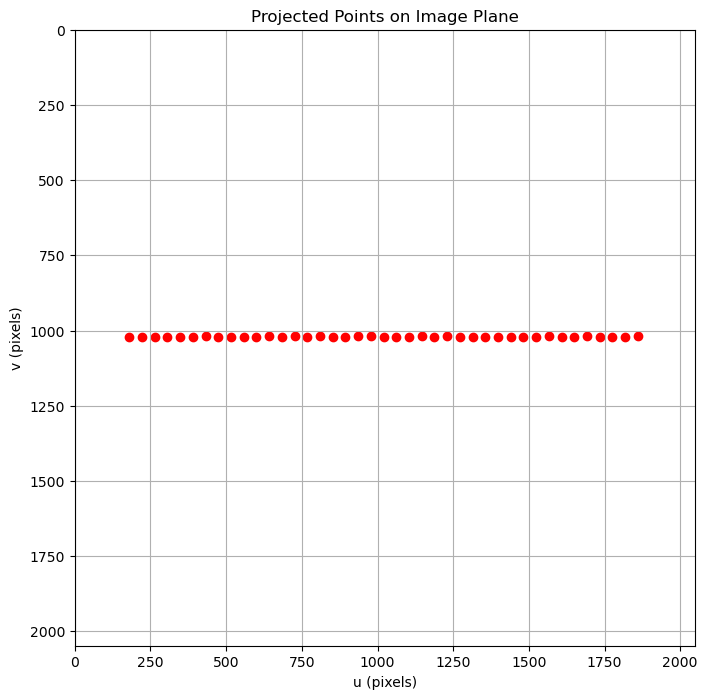

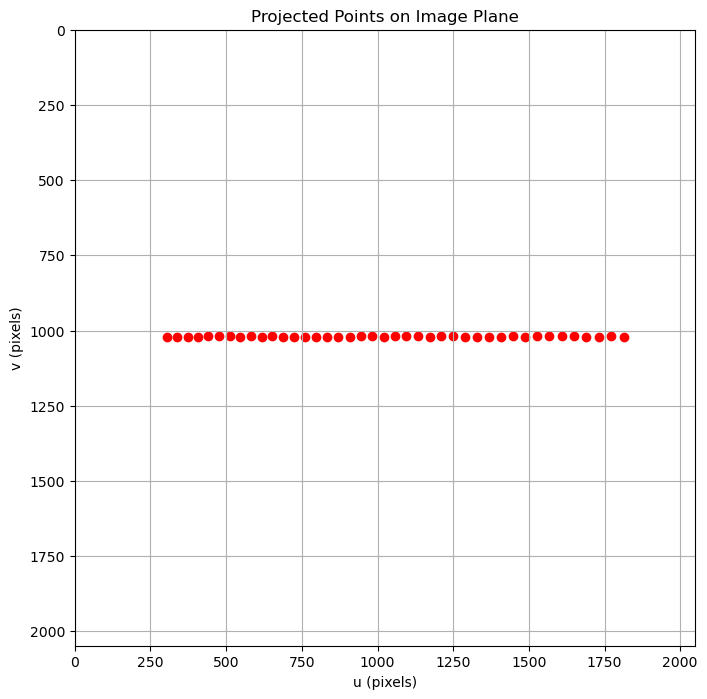

In [5]:
#Generate data
fx = 1260  # Focal length in x (pixels)
fy = 1260  # Focal length in y (pixels)
u0 = 1020  # Principal point x-coordinate (pixels)
v0 = 1020  # Principal point y-coordinate (pixels)
img_width = 2048  # Image width (pixels)
img_height = 2048  # Image height (pixels)

h = 60
l = 10

rx_deg = 180    # Rotation around x-axis
ry_deg = 0   # Rotation around y-axis
rz_deg = 0    # Rotation around z-axis

t1 = np.array([0, 0, 1800])  # Translation vector (mm)
t2 = np.array([0, 0, 2000])  # Translation vector (mm)

# Instantiate the class
camera_projection_0 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, ry_deg, rz_deg, t1)
camera_projection_5 = CameraProjection(fx, fy, u0, v0, img_width, img_height, rx_deg, 5, rz_deg, t2)

# Project points and plot
u_valid_0, v_valid_0 = camera_projection_0.project_points(0.1, point_distance=h,num_points=41)
u_valid_5, v_valid_5 = camera_projection_5.project_points(0.1, point_distance=h,num_points=41)
camera_projection_0.plot_points(u_valid_0, v_valid_0)
camera_projection_5.plot_points(u_valid_5, v_valid_5)

(40, 2)
(40, 2)
2


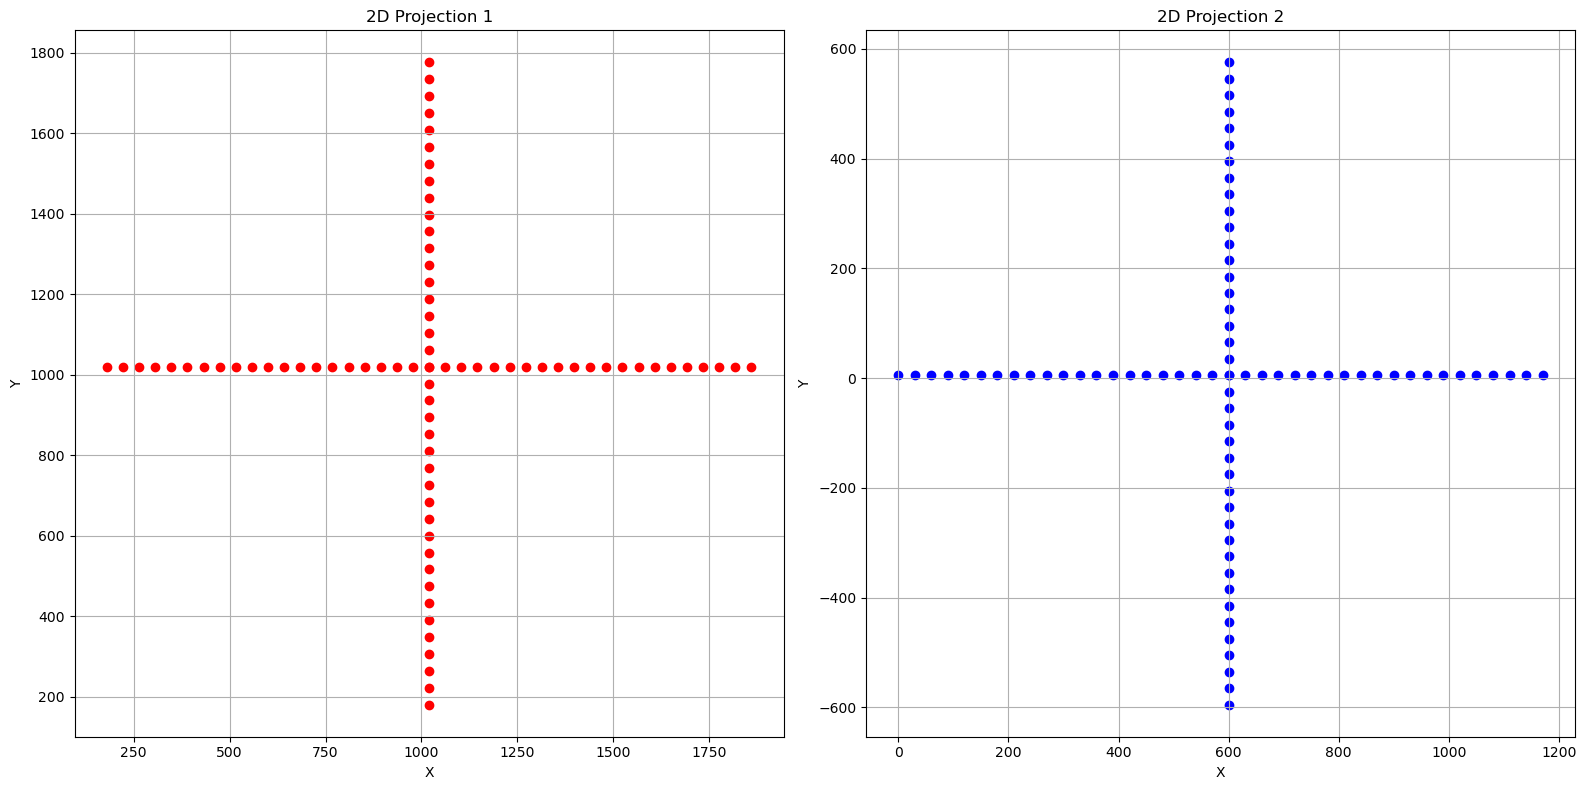

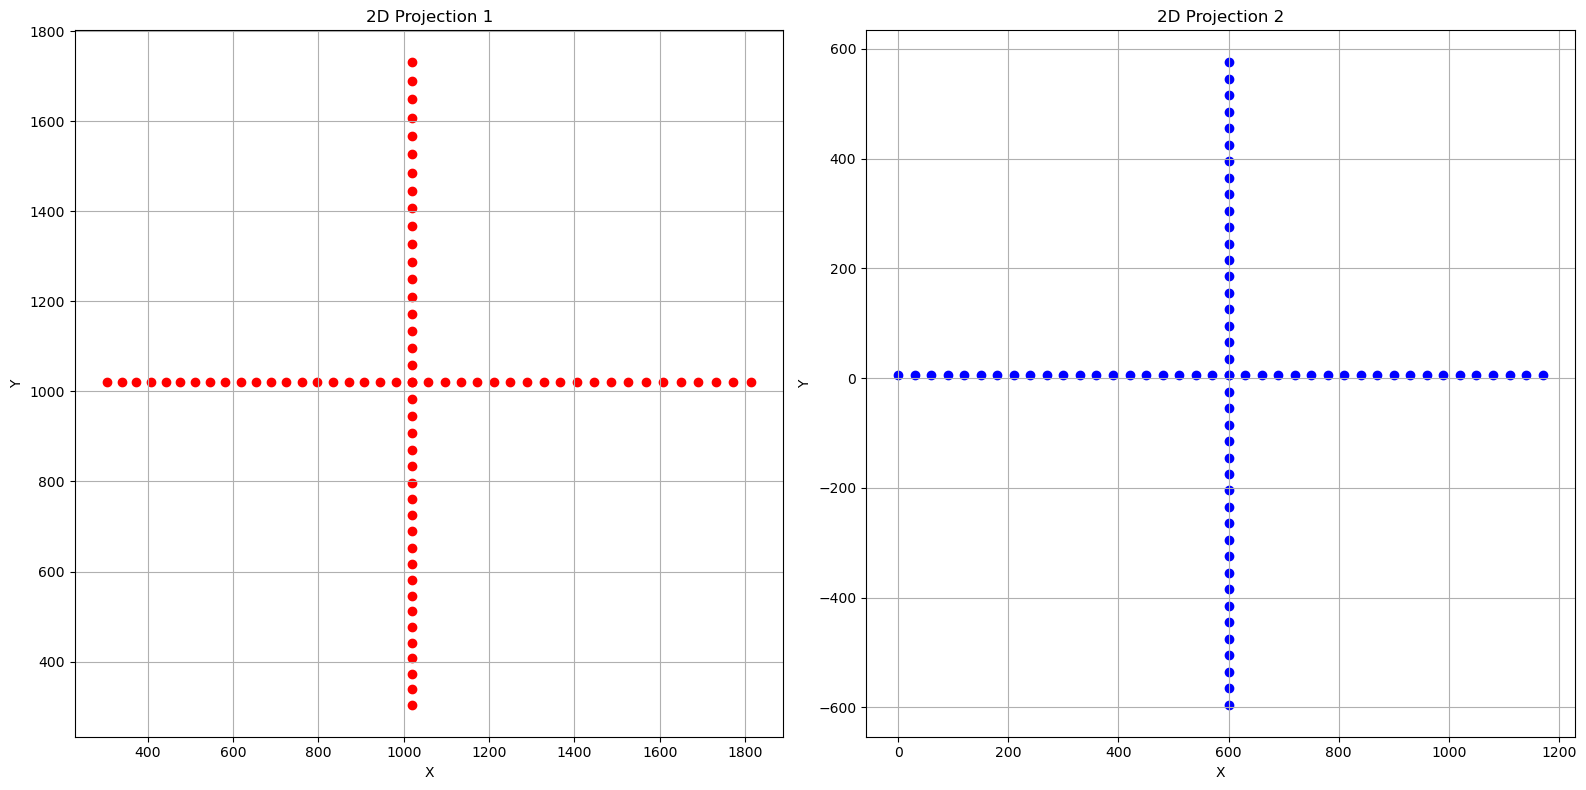

In [6]:
def plot_2d_projections(points_2d_1, points_2d_2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the first set of points
    axes[0].scatter(points_2d_1[:, 0], points_2d_1[:, 1], color='red', marker='o')
    axes[0].set_title("2D Projection 1")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    axes[0].grid(True)
    
    # Plot the second set of points
    axes[1].scatter(points_2d_2[:, 0], points_2d_2[:, 1], color='blue', marker='o')
    axes[1].set_title("2D Projection 2")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


images_Xaxis = [u_valid_0, u_valid_5] # Get X data from images (WE CANNOT USE Y IN REAL EXAMPLE)
u_init = 1020 # Set the guess of the optical center 
image_2d = [] 
pattern_2d = []

for u_valid in images_Xaxis:
    pattern_coordinates = feature_points_correspondences(np.array(u_valid),h,l) # Find world coordinates!
    print(pattern_coordinates.shape)
    #plot_2d_projection(pattern_coordinates) 

    image_2d_temp = project_feature_points_1d_to_2d(u_valid, u_init) # Make the 1D image points into a 2D with the optical center as the middle
    pattern_2d_temp = project_pattern_points(u_valid, pattern_coordinates, u_init) # Make the 1D world coordnates into 2D with the optical center projected and as the middle

    image_2d_temp = image_2d_temp[:pattern_2d_temp.shape[0], :] # Make sure that Image 2D is the same size as the world coordinates

    #plot_2d_projection(image_2d)
    #plot_2d_projection(pattern_2d)
    image_2d.append(image_2d_temp)
    pattern_2d.append(pattern_2d_temp)

print(len(image_2d))
plot_2d_projections(image_2d[0],pattern_2d[0])
plot_2d_projections(image_2d[1],pattern_2d[1])


In [12]:
h1, status = cv2.findHomography(pattern_2d[0], image_2d[0], cv2.RANSAC, 5.0) # Find homographyes with CV2
h2, status = cv2.findHomography(pattern_2d[1], image_2d[1], cv2.RANSAC, 5.0)

H_list = [h1, h2] # Make a list of them
calibrate_from_homographies(H_list) # Find closed form solution !!NOT WORKING!!
calibrate_from_homographies_LMA(H_list) # Find closed form solution WITH LMA !!NOT WORKING!!

Intrinsic Matrix M:
[[4.36854001e+03 0.00000000e+00 1.98074694e+03]
 [0.00000000e+00 4.36854001e+03 1.98074694e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Parameters for Homography 1:
Rotation Matrix R:
[[ 9.98593091e-01  5.30263467e-02 -2.12530283e-04]
 [-4.82357317e-02  9.10026381e-01  4.11734501e-01]
 [ 2.20261846e-02 -4.11144976e-01  9.11303822e-01]]
Translation Vector t:
[-906.91218332 -488.17438698 2201.13918478]

Extrinsic Parameters for Homography 2:
Rotation Matrix R:
[[ 9.80888329e-01 -4.84916971e-04  1.94570940e-01]
 [-1.10047677e-01  8.23301528e-01  5.56834000e-01]
 [-1.60460571e-01 -5.67604052e-01  8.07513496e-01]]
Translation Vector t:
[-815.95605407 -471.26627173 2127.52924204]
Intrinsic Matrix M:
[[inf  0. inf]
 [ 0. inf inf]
 [ 0.  0.  1.]]


C:\Users\Bruger\AppData\Local\Temp\ipykernel_15984\2369876202.py:292: RuntimeWarning: overflow encountered in scalar divide
  fx = np.sqrt(1 / B11)


(array([[inf,  0., inf],
        [ 0., inf, inf],
        [ 0.,  0.,  1.]]),
 [])